We want to minimize the following expectation
$$\underset{\phi}{\min} \mathbb{E}_{q_\phi (x)}[f(x)]$$
We need to compute the gradient w.r.t. $\phi$. We apply the likelihood ratio trick:

\begin{eqnarray}
\nabla_\phi \mathbb{E}_{q_\phi (x)}[f(x)] & = & \nabla_\phi \sum_x q_\phi (x) f(x) \\
& = & \sum_x \nabla_\phi q_\phi (x) f(x) \\
& = & \sum_x q_\phi (x) \frac{\nabla_\phi q_\phi (x)}{q_\phi (x)} f(x)\\
& = & \mathbb{E}_{q_\phi (x)} \nabla_\phi \log q_\phi(x) f(x) \\
& = & \frac{1}{K} \sum_{i = 1}^K \nabla_\phi \log q_\phi (x^{(i)}) f(x^{(i)})
\end{eqnarray}

where $x^{(i)} \sim q_\phi (x)$.

This gradient estimate usually has high variance because:
- $q_\phi(x)$ is usually a high dimensional distribution, the number of
samples needed to reliably estimate the mean is exponential
- $q_\phi(x)$ is very small for most $x$, making $\log q_\phi(x)$ very large.
This contributes to the variance of the estimate (the sample mean).

This Likelihood Ratio Gradient has high variance, especially in higher dimensional spaces.
An example in 2D:

Minimize the following loss function:

\begin{eqnarray}
\mathcal{L} = \mathbb{E}_{\mathcal{N}(\mu, I)} \left[\left\lvert\left\lvert x - \left[ \begin{matrix} 5 \\ 5 \end{matrix} \right] \right\rvert\right\rvert_2^2 \right]
\end{eqnarray}


Apply the formula

\begin{eqnarray}
\nabla_\mu \mathcal{L} & = & \mathbb{E}\left[\nabla_\mu \log \left(\exp\left(-\frac{1}{2} (x - \mu)^\top I (x-\mu) \right)\right) f(x)\right] \\
& = & \mathbb{E} \left[\left\lvert\left\lvert x -
\left[
\begin{matrix}
5 \\
5
\end{matrix}
\right]
\right\rvert\right\rvert_2^2 \nabla_\mu -\frac{1}{2} (x - \mu)^\top (x-\mu)  \right] \\
& = & \mathbb{E} \left[  \left\lvert\left\lvert x - \left[ \begin{matrix} 5 \\ 5 \end{matrix} \right] \right\rvert\right\rvert_2^2 (x - \mu) \right]
\end{eqnarray}


In [1]:
import numpy as np
from matplotlib import pyplot as plt

mu = np.array([0, 0])
target = np.array([5, 5])
I = np.array([[1, 0], [0, 1]])
n=40

x = np.random.multivariate_normal(mean=mu, cov=I, size=(n,))

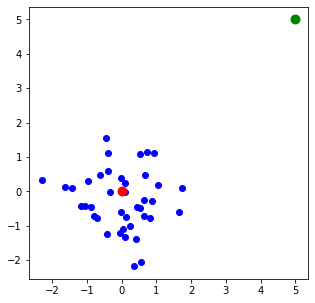

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x[:, 0], x[:, 1], c='b')

ax.scatter(mu[0], mu[1], c='r', s=80)
ax.scatter(target[0], target[1], c='g', s=80)

In [3]:
def loss(z, target):
    return (np.linalg.norm(z - target, axis=1) ** 2).mean()

def lrg(z, mu, target):
    norm = np.linalg.norm(z - target, axis=1) ** 2
    # print('norm', norm)
    # print('z - mu', z - mu)
    grad = (norm[:, np.newaxis] * (z - mu)).mean(axis=0)

    # print('grad', grad)

    return grad

def train(mu, target, loss, lr, n_train, n_test, n_iter=10, viz=False):
    for it in range(n_iter):

        z = np.random.multivariate_normal(mean=mu, cov=I, size=n_train)
        pmu = mu
        lrgi = lrg(z, mu, target)
        mu = mu - lr * lrgi

        # visualization
        if viz:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.set_xlim(-5, 6)
            ax.set_ylim(-5, 6)
            ax.scatter(z[:, 0], z[:, 1], c='b')

            ax.scatter(pmu[0], pmu[1], c='r', s=80, alpha=0.5)
            ax.scatter(mu[0], mu[1], c='r', s=80)
            ax.arrow(pmu[0], pmu[1], mu[0] - pmu[0], mu[1] - pmu[1], head_width=0.1, length_includes_head=True)
            ax.scatter(target[0], target[1], c='g', s=80)

        z_test = np.random.multivariate_normal(mean=mu, cov=I, size=n_test)
        lossi = loss(z_test, target)
        print(it, lossi)

When `n_train = 1`, the training is very unstable.
It diverges when `lr = 0.1` and converges slowly when `lr = 0.01`.

It is interesting to analyze the learning dynamic of the algorithm:

When `lr` is large, if we sample a bad datapoint (a datapoint closer to `target` than `mu`),
then `mu` is pushed further away from `target` by a large amount.
The error grows exponentially.

When `lr` is small, if a bad datapoint is sampled, `mu` moved by a only a small amount.
That (small) wrong update is corrected by other datapoints sampled later in the process.
Using smaller learning rate is similar to `wait' for more examples to be avaialble before
making a step.

Unstable------------
0 47.07664871503509
1 109.96341920593937
2 1512.8530110231347
3 58307.84465072739
4 28236457.923201572
5 24220320585291.246
6 1.1161931330103906e+24
7 6.629321214725887e+45
8 6.629321214725887e+45
9 6.629321214725887e+45
10 6.629321214725887e+45
11 6.629321214725887e+45
12 6.629321214725887e+45
13 6.629321214725887e+45
14 6.629321214725887e+45
15 6.629321214725887e+45
16 6.629321214725887e+45
17 6.629321214725887e+45
18 6.629321214725887e+45
19 6.629321214725887e+45


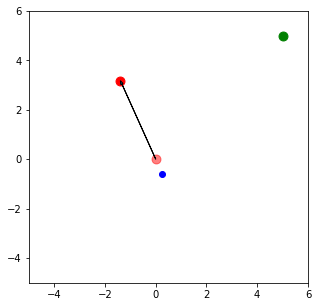

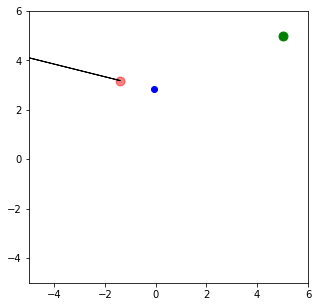

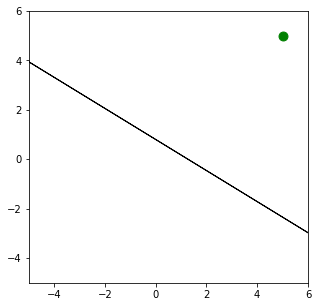

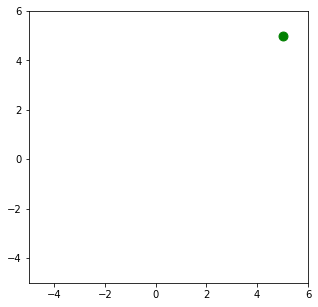

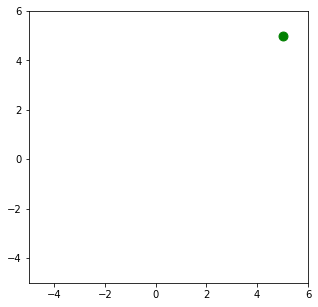

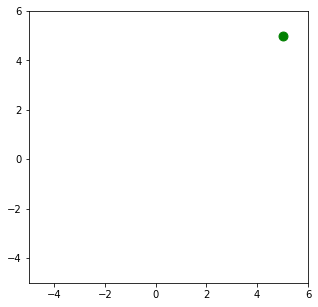

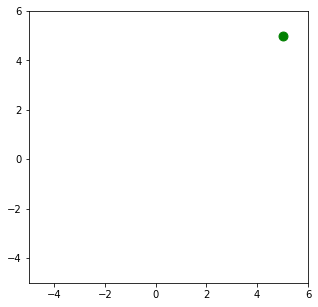

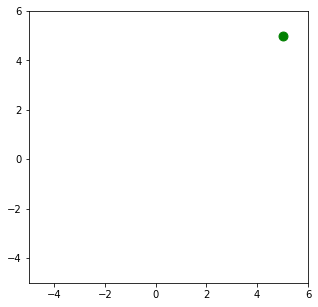

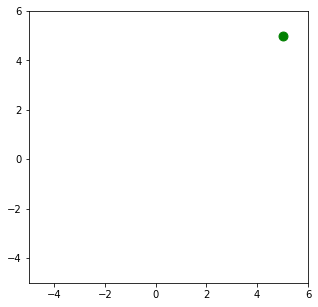

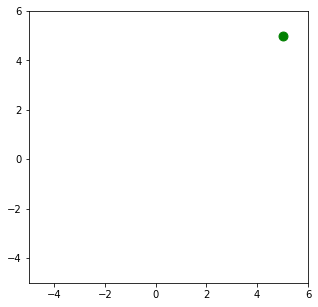

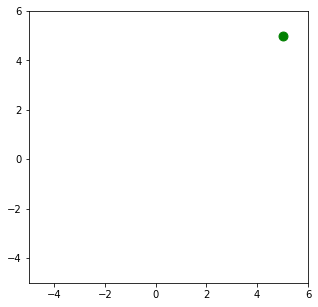

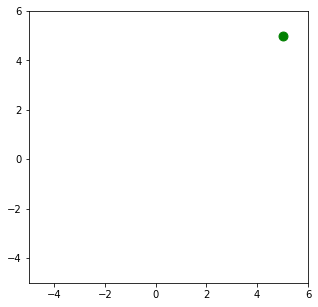

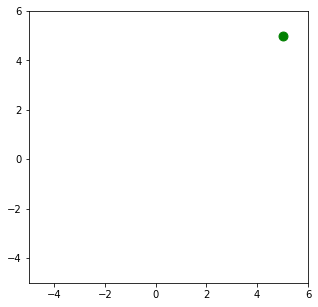

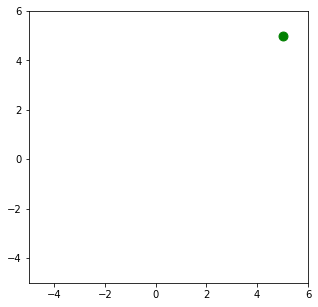

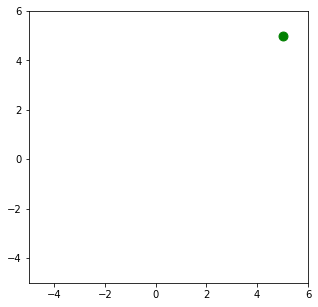

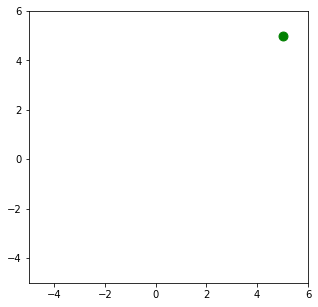

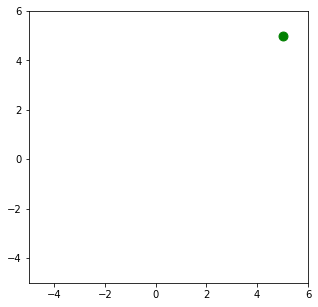

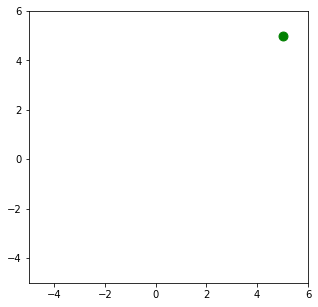

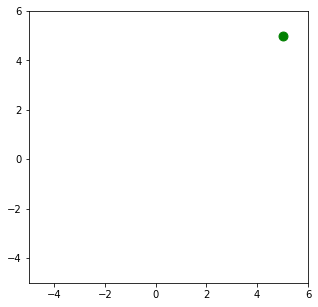

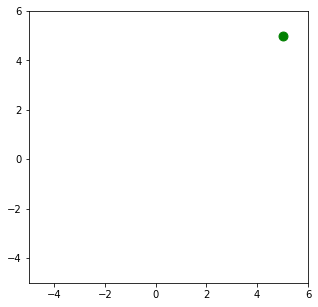

In [4]:
## unstable learning rate
print('Unstable------------')
train(mu, target, loss, lr=0.1, n_train=1, n_test=100, n_iter=20, viz=True)

Stable-----------
0 42.295177970620806
1 44.501908019954634
2 46.95845062789048
3 48.59179055853513
4 56.31308194552585
5 47.611916160959964
6 56.82817953802033
7 29.051945065181577
8 32.942833959676726
9 34.7118340107096
10 32.14427110753174
11 38.175430408420404
12 39.73686748756192
13 39.23448370371862
14 31.88966163882957
15 32.38954231649844
16 32.39274593753226
17 25.515780413370713
18 26.435810681799957
19 30.286372981531393
20 22.86007510290285
21 24.875220938644834
22 17.455341539979685
23 17.91805702451437
24 16.772029102232526
25 17.52988371405435
26 16.578890168275365
27 16.1379148612925
28 16.60531599880622
29 17.139090602971773
30 15.31230224083058
31 14.057971977875567
32 12.641879992815554
33 12.191640410630944
34 13.325488180020024
35 12.741751382904402
36 9.461845305715155
37 7.790591829701458
38 7.371910428658213
39 8.004711211325633
40 8.11414376981066
41 8.465622304301853
42 7.982519548387591
43 7.389865535769055
44 8.153217738154018
45 8.058666663882944
46 7.18012

<ipython-input-3-03df4d4c30f5>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))


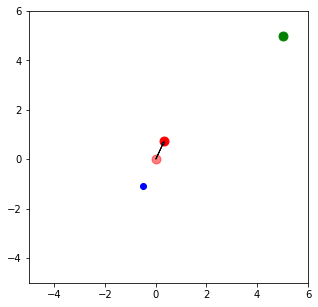

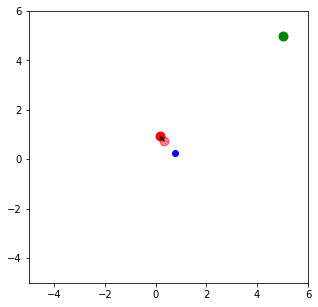

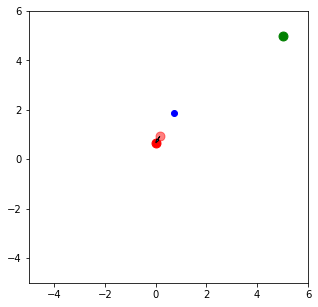

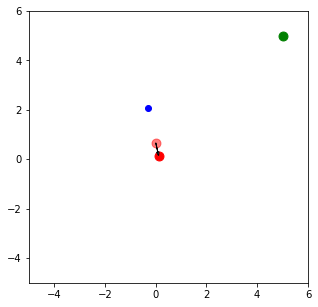

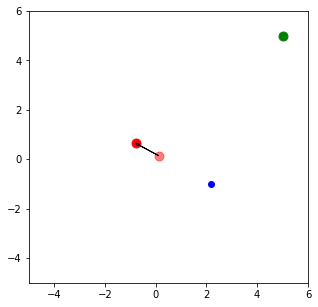

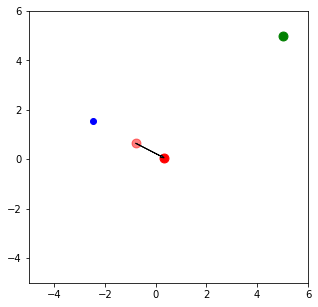

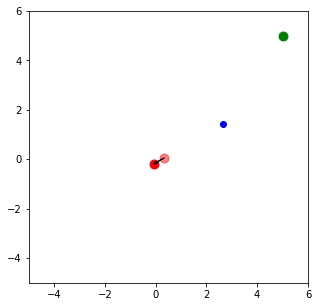

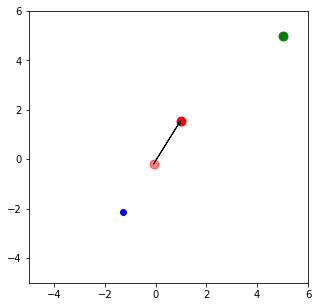

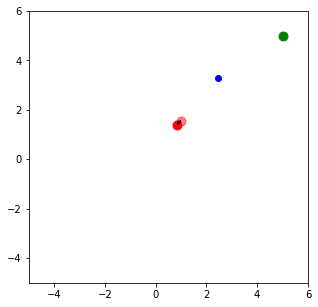

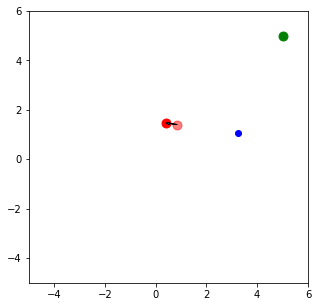

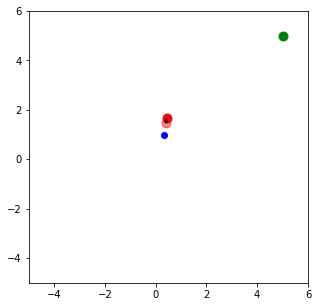

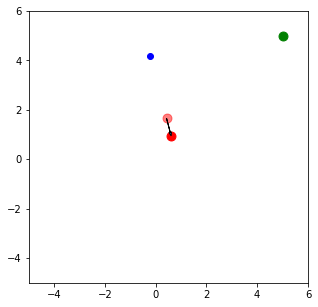

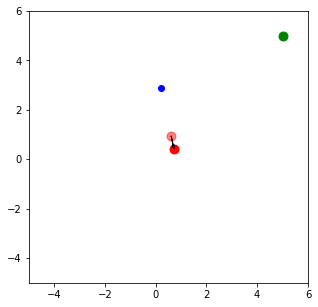

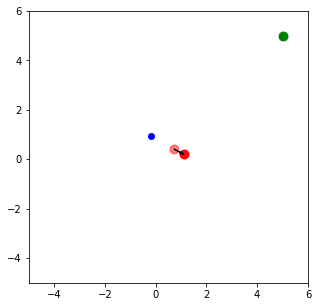

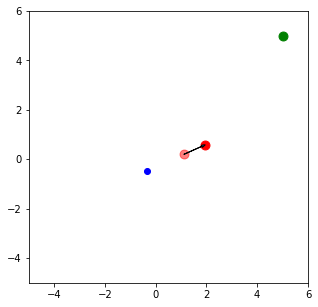

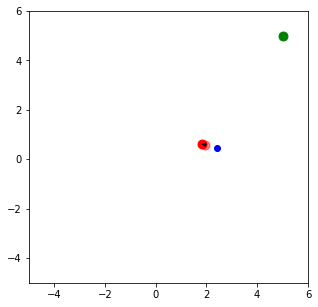

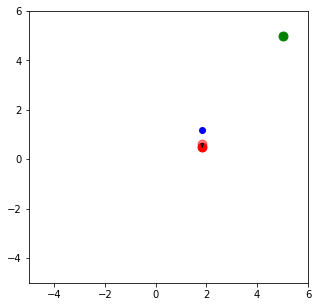

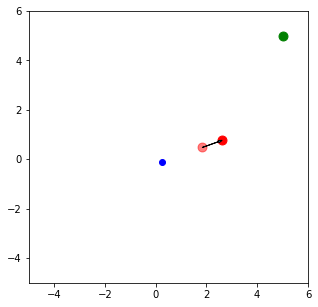

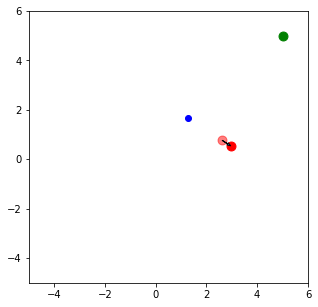

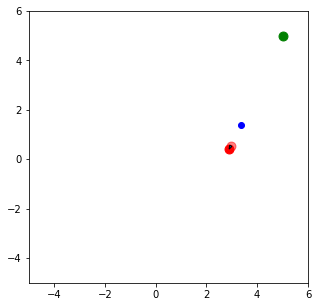

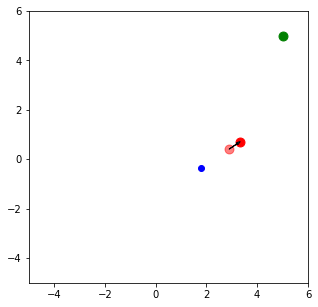

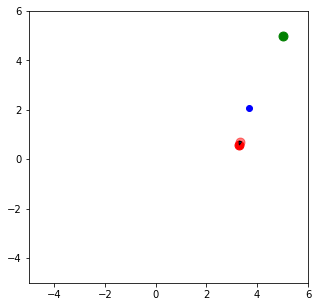

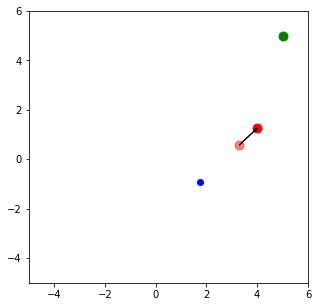

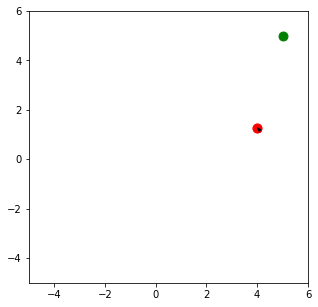

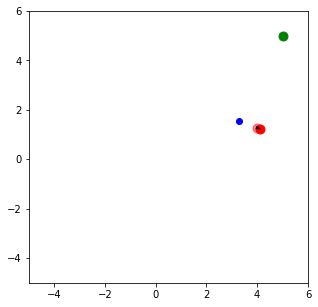

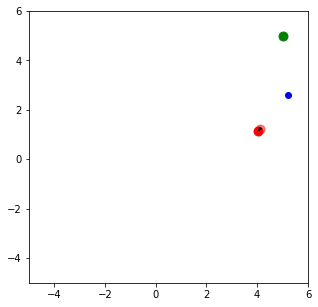

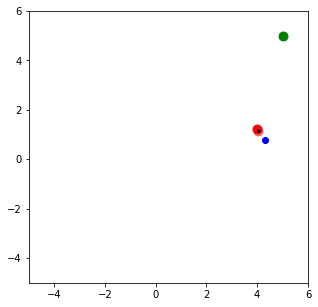

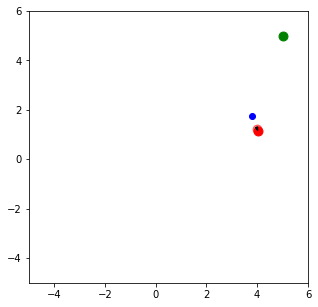

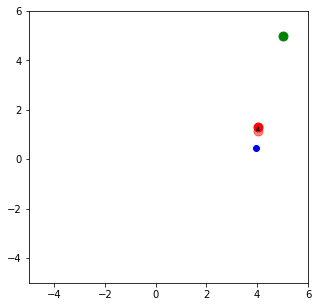

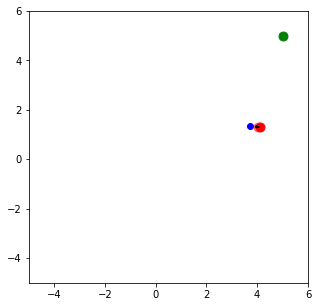

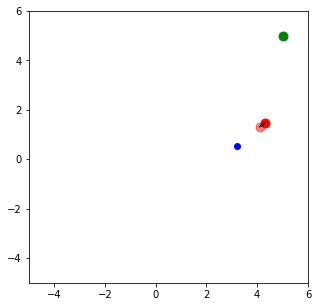

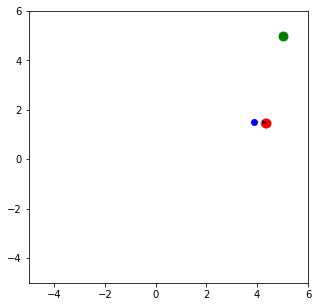

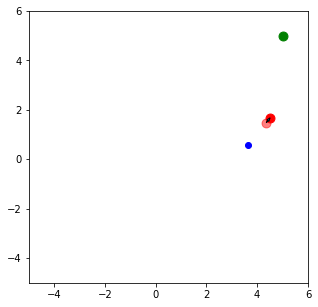

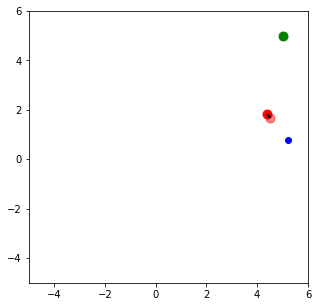

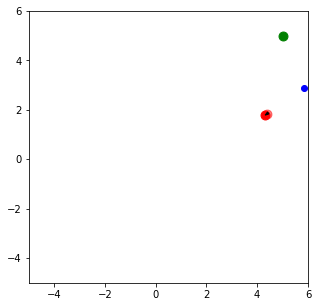

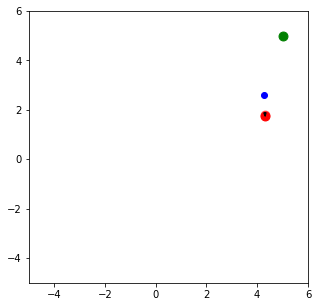

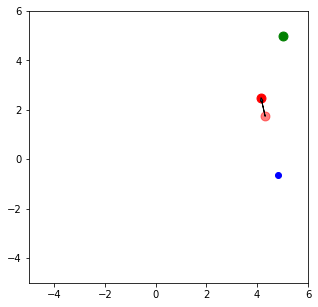

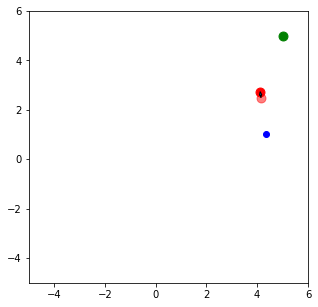

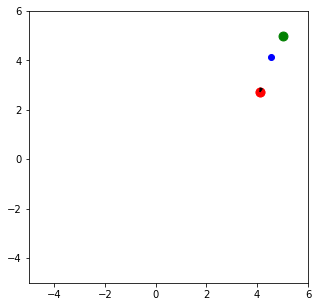

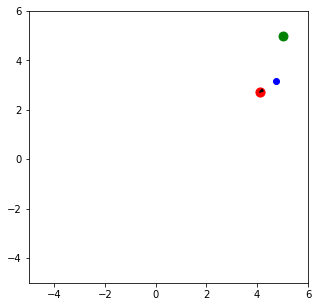

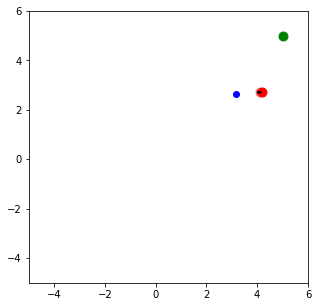

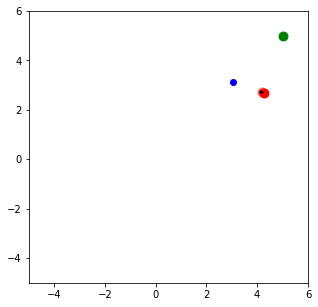

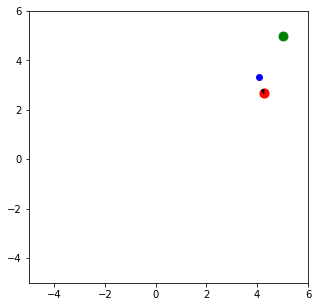

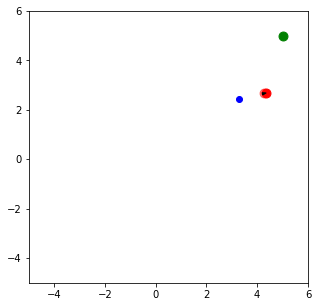

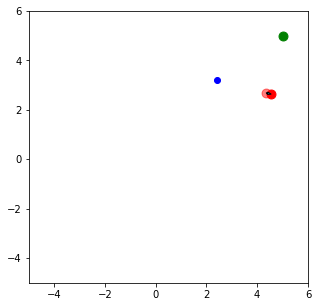

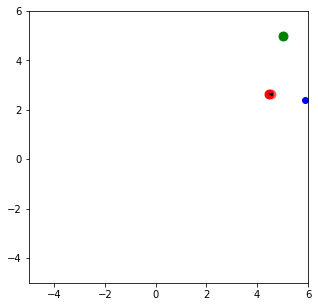

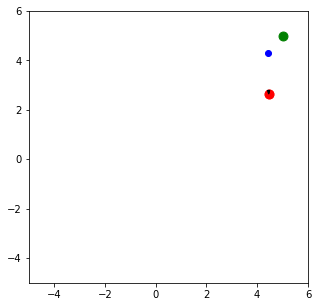

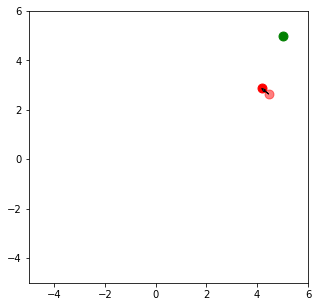

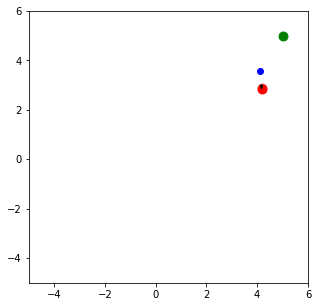

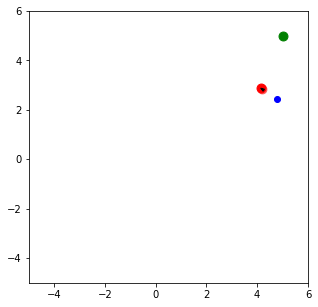

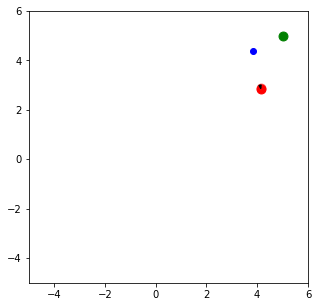

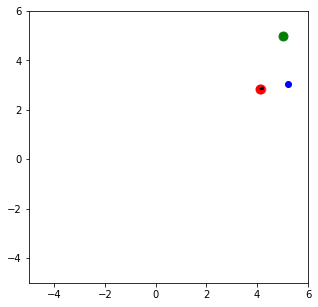

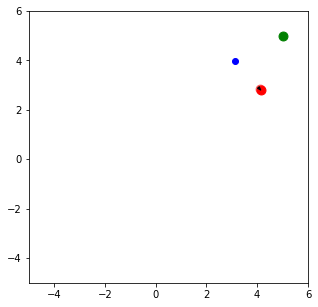

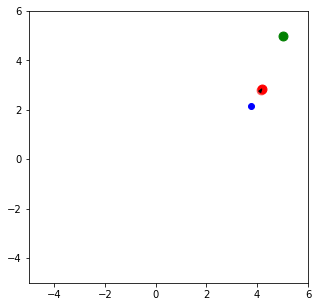

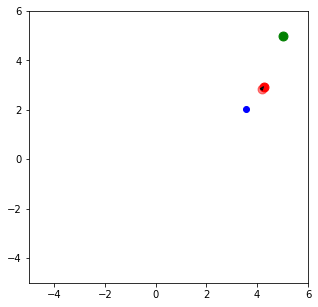

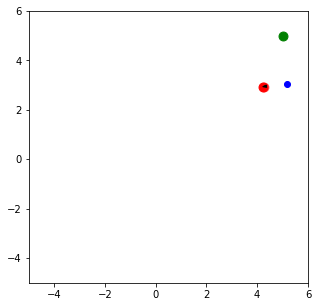

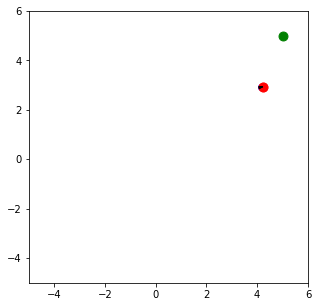

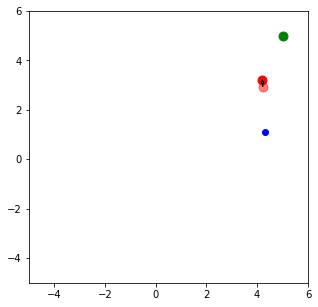

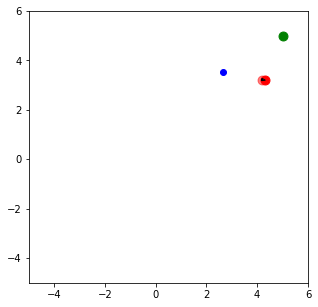

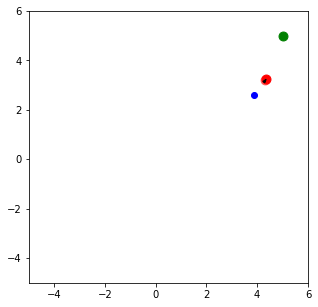

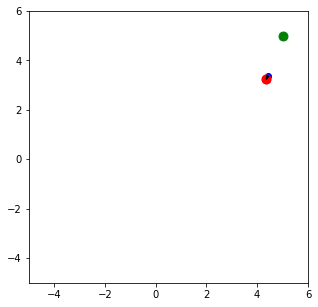

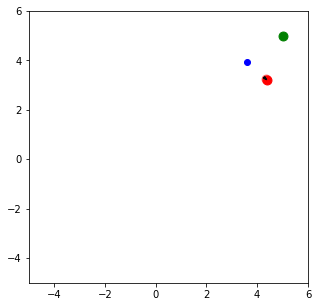

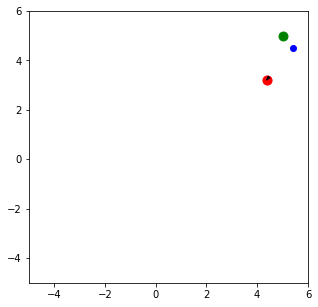

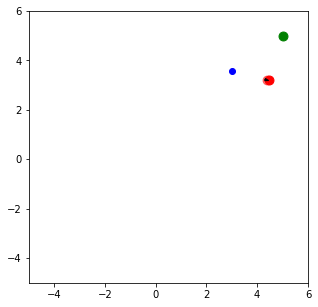

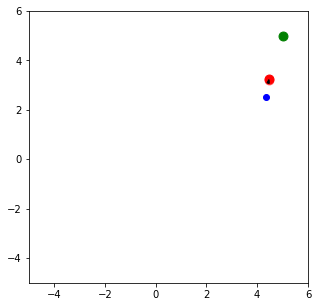

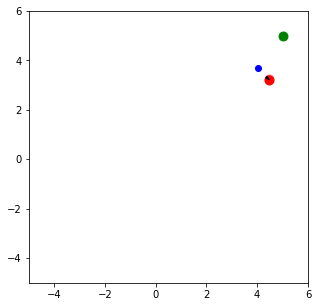

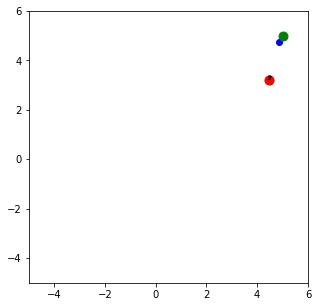

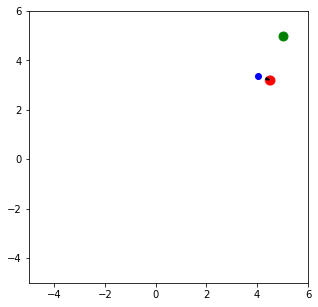

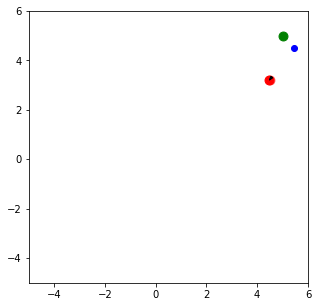

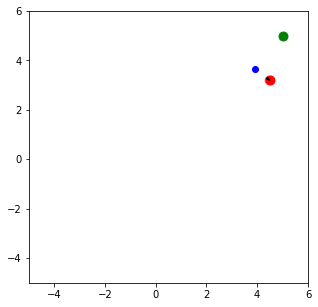

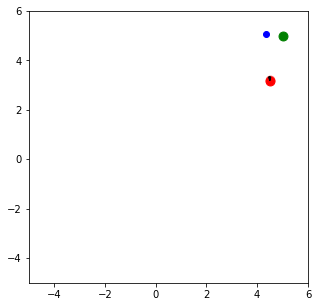

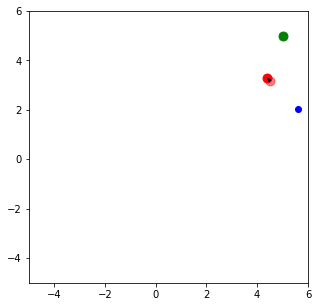

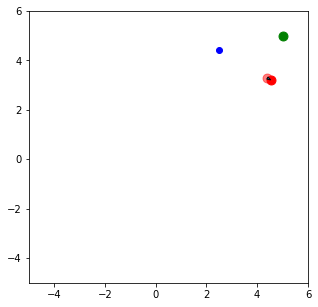

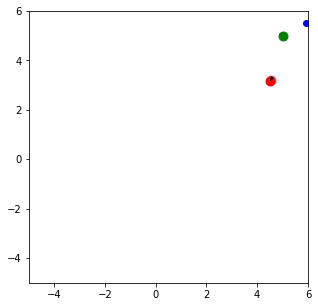

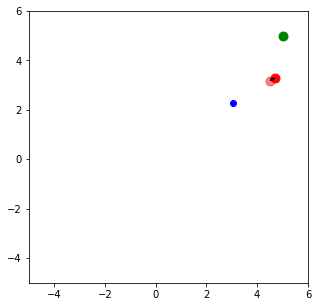

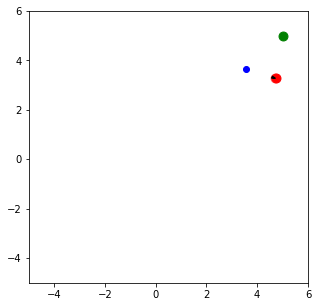

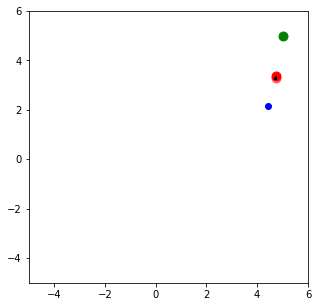

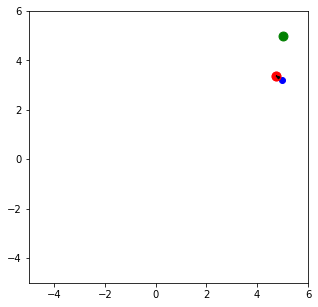

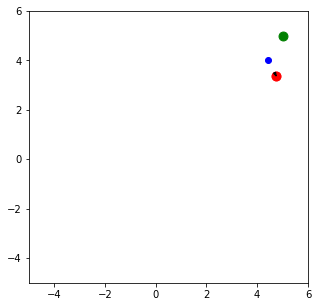

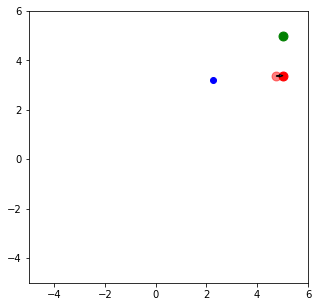

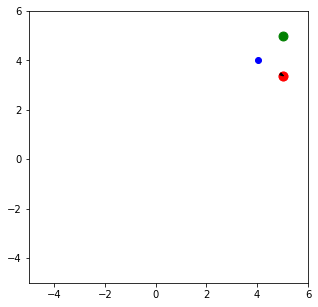

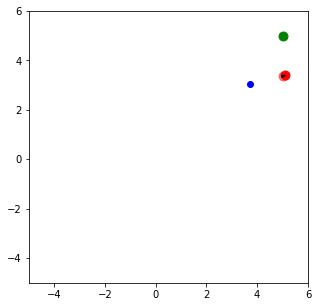

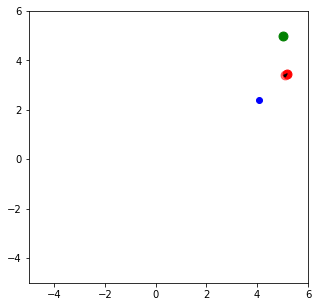

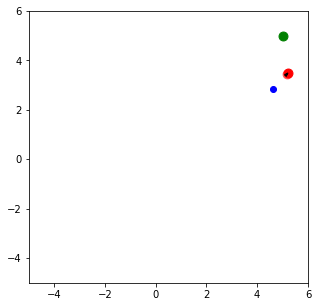

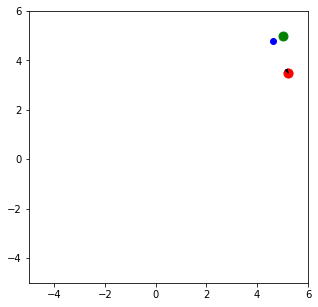

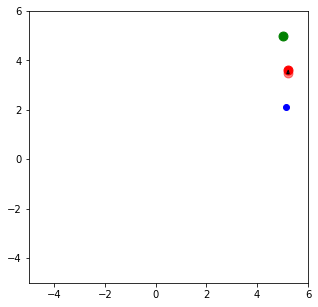

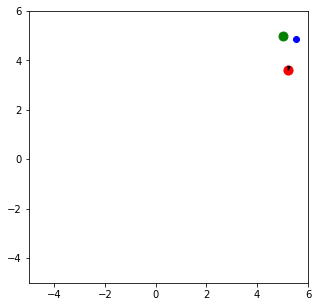

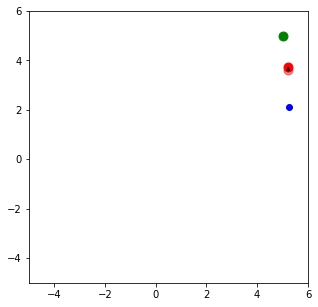

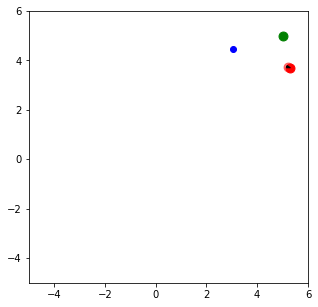

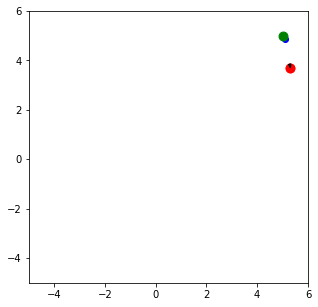

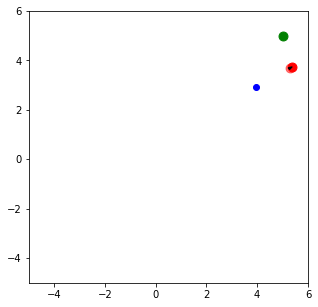

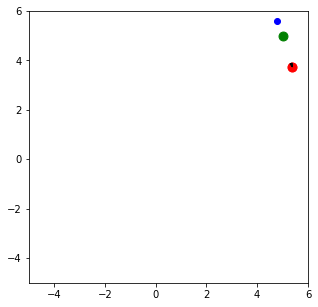

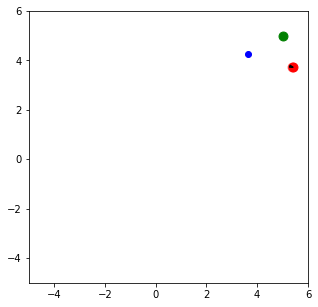

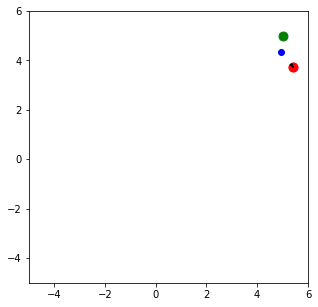

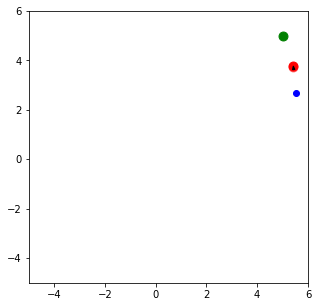

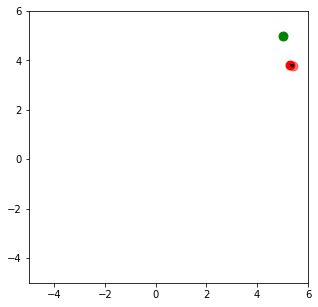

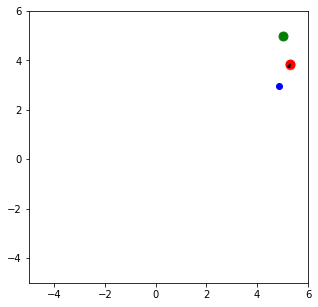

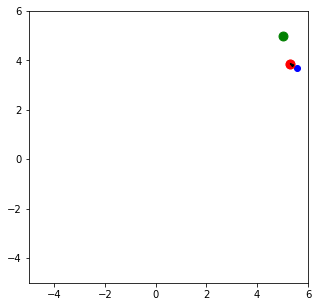

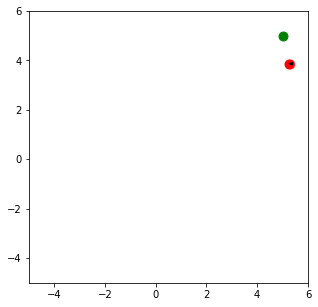

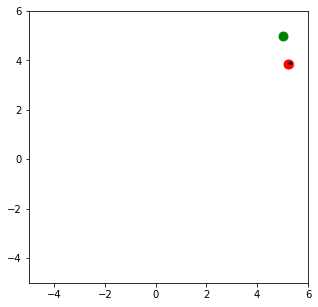

In [5]:
## stable learning rate
print('Stable-----------')
train(mu, target, loss, lr=0.01, n_train=1, n_test=100, n_iter=100, viz=True)


Increasing `n_train` improve the stability of the training. Now `lr = 0.1` and greater still works well.
We can learn much faster due to larger learning rate.

This is because the gradient signal given by `1` training datapoint is too noisy/wrong.
If we sample a datapoint closer to `target` then we end up pushing `mu` away from `target`.

Increasing `n_train` lowers the variance of the gradient, making the training more stable.
However, this solution quickly become intractable for high dimensional distributions.
The number of samples needed to reliably estimate $\mathbb{E}_{q_\phi (x)}[f(x)]$ grows
exponentially with the number of dimensions of $q_\phi$.

0 45.861567198506094
1 29.897158141533325
2 19.31219271985873
3 9.95181311737316
4 10.01665690019517
5 6.284998963885491
6 4.714148674327708
7 3.192859301495716
8 2.978708532633332
9 2.516272318054261
10 3.206005206072892
11 2.812497878648764
12 2.058469139545333
13 1.9980211187309964
14 2.393471857170244
15 1.8357484613392683
16 2.2497595114717144
17 2.1728694390676733
18 2.1294230339704234
19 2.1292869795727807
20 1.7209535895575392
21 2.3449203897712207
22 1.9872179500510203
23 1.6576770369407563
24 2.013230077589817
25 1.8766879392132088
26 2.0640282812044286
27 2.457039605407692
28 2.214565238571329
29 1.7471167546257633
30 2.1610680036241683
31 1.858718615427988
32 2.3402288310989166
33 2.007609384756522
34 1.792683125950741
35 2.2538258926852666
36 1.9065705806228865
37 2.3471576469071946
38 1.8271015894285245
39 1.8061928057545797
40 2.0977480952555747
41 1.7231467563712415
42 2.0290330942977683
43 1.7451708474636047
44 1.8146213529671322
45 2.138086701056324
46 2.0193987530668

<ipython-input-3-03df4d4c30f5>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))


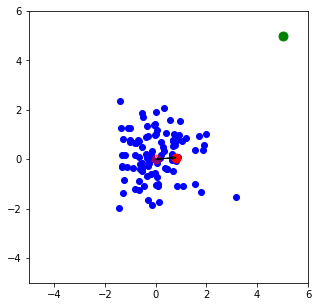

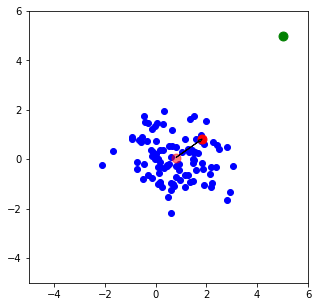

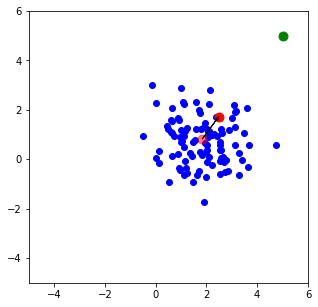

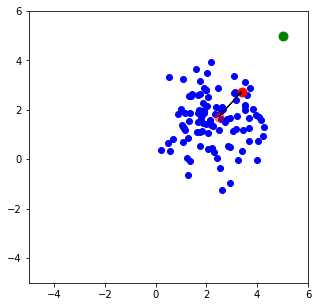

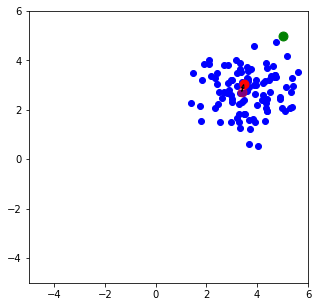

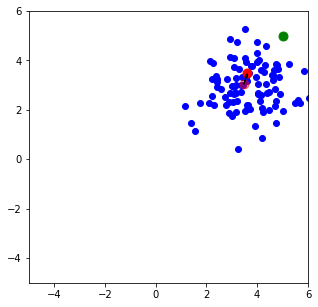

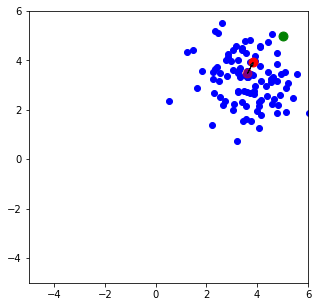

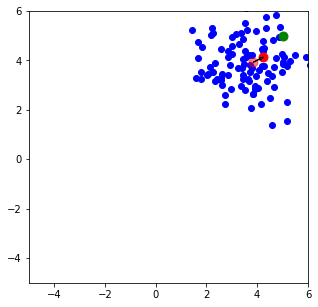

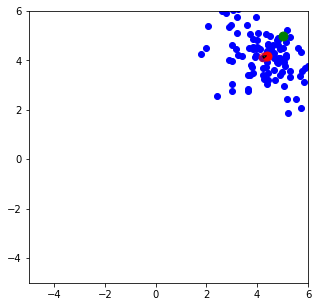

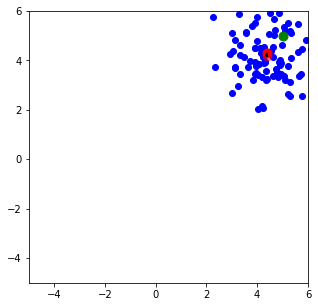

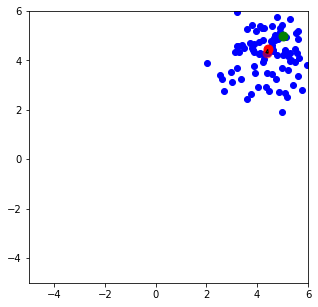

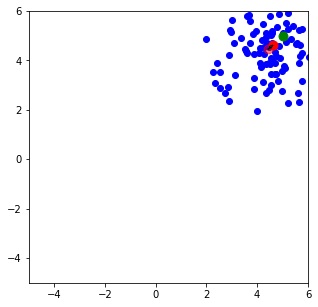

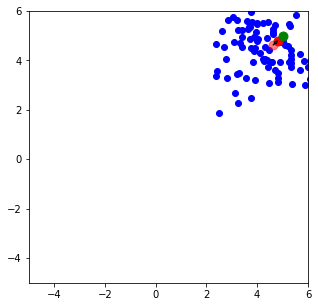

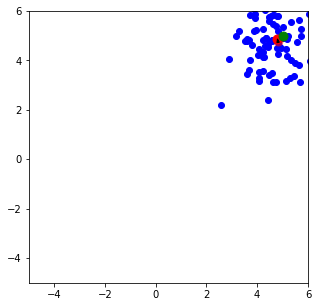

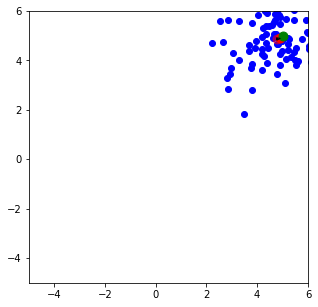

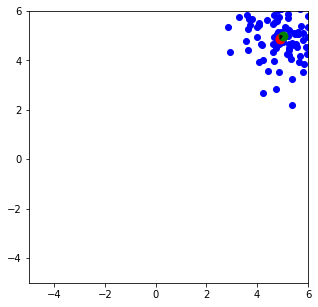

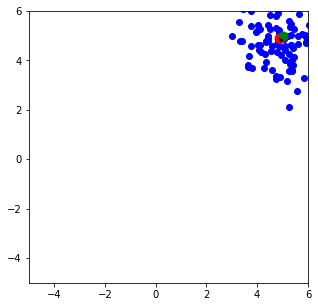

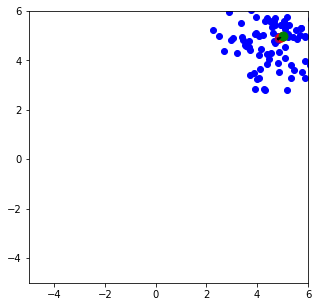

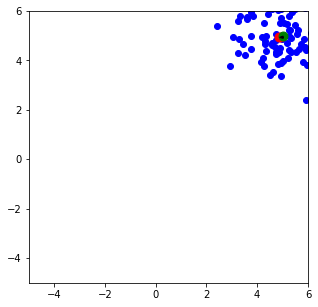

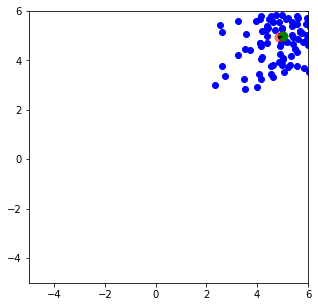

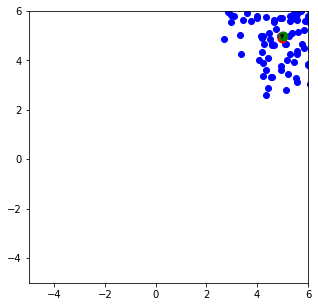

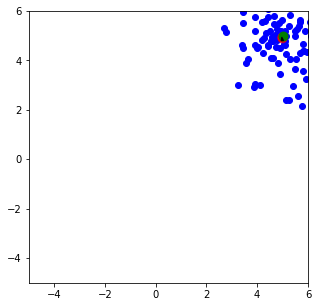

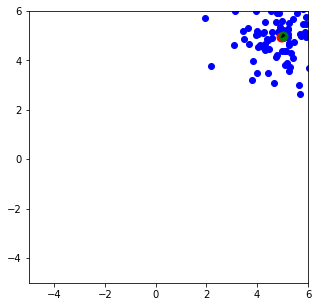

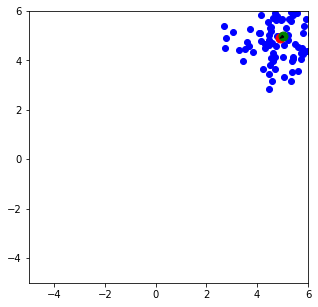

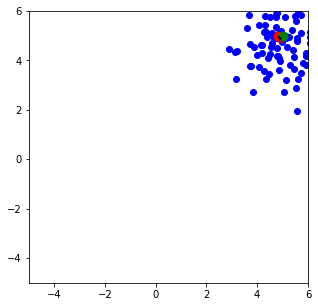

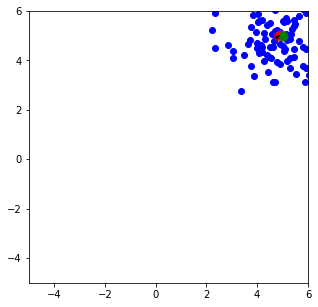

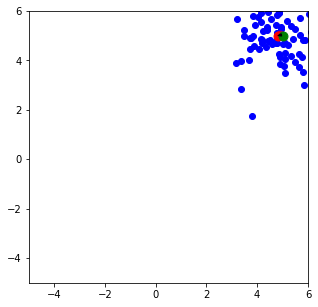

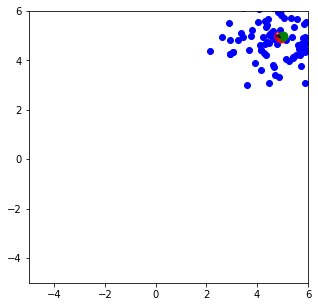

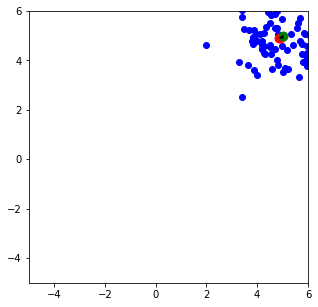

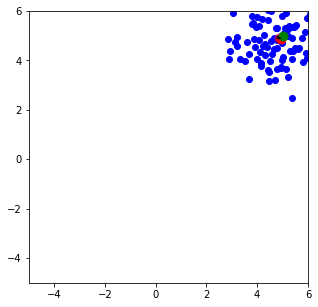

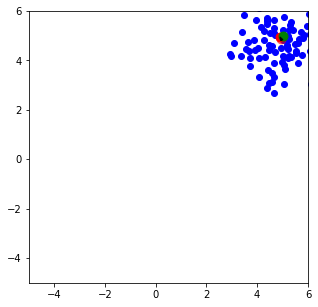

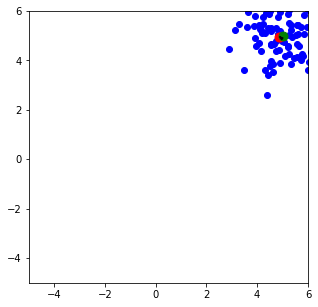

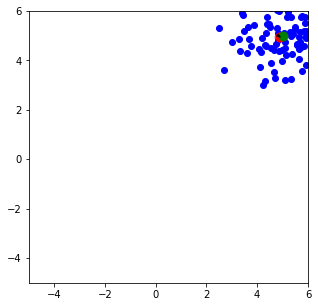

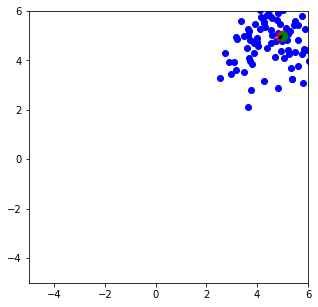

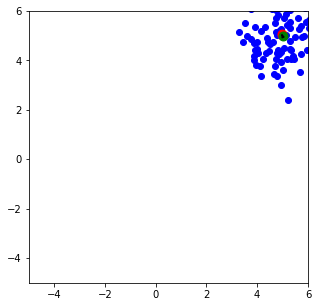

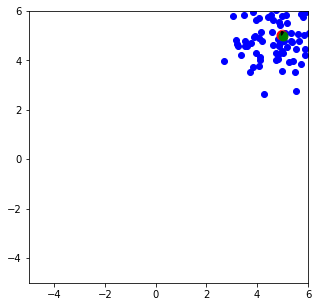

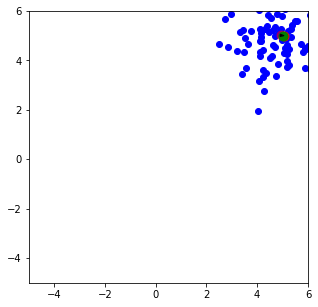

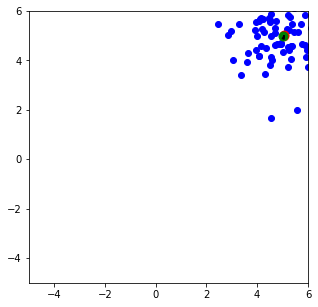

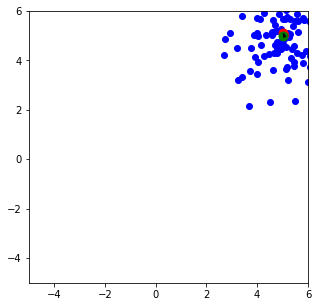

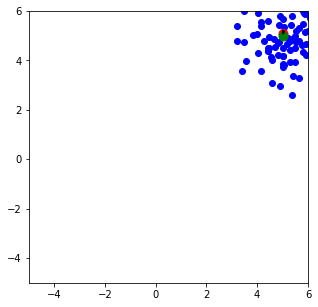

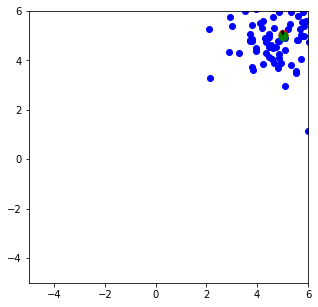

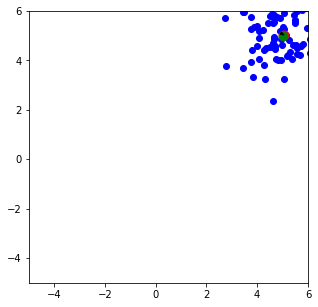

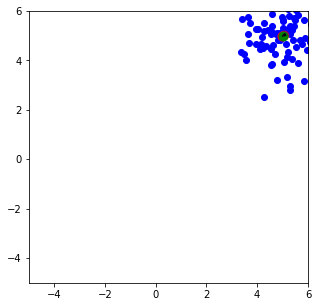

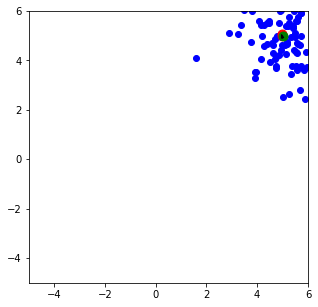

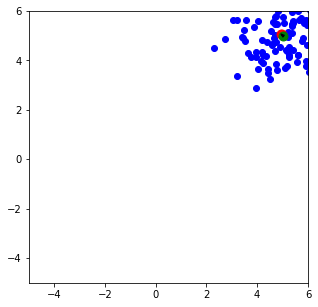

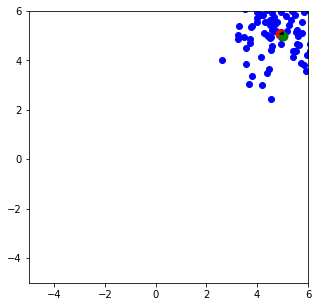

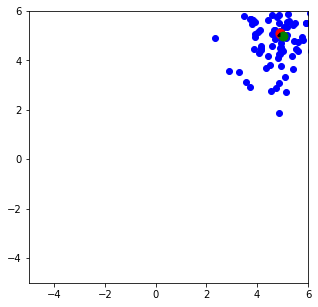

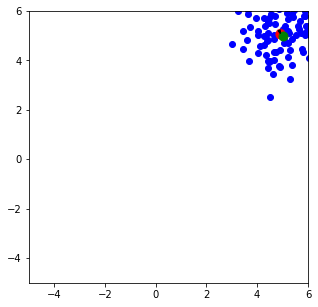

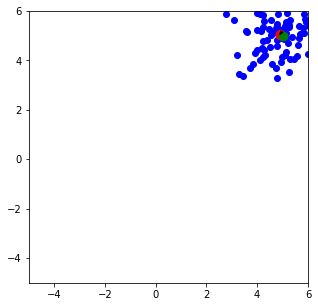

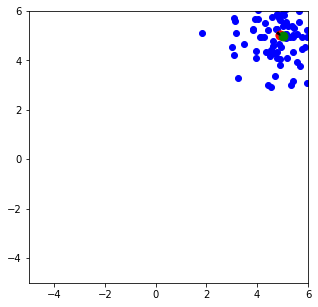

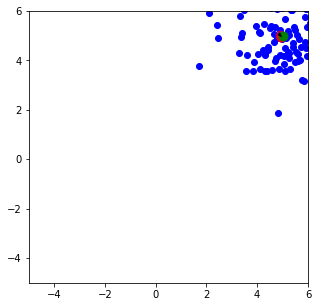

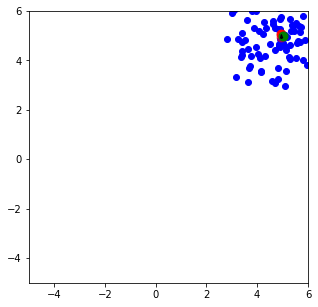

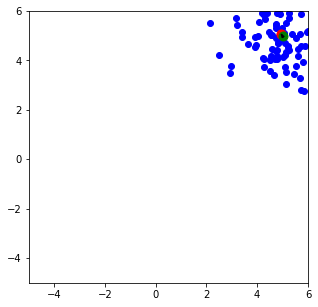

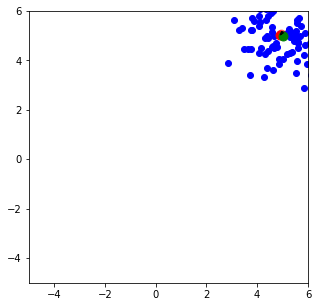

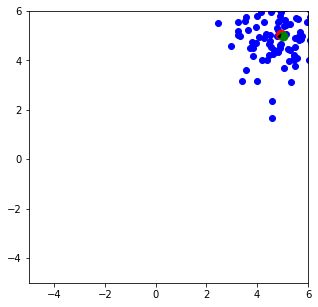

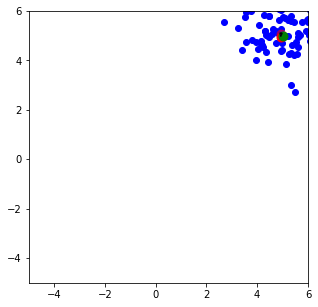

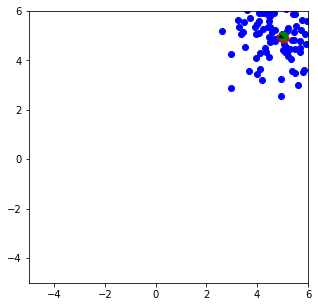

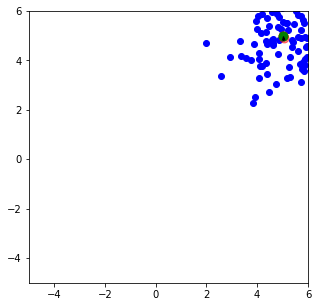

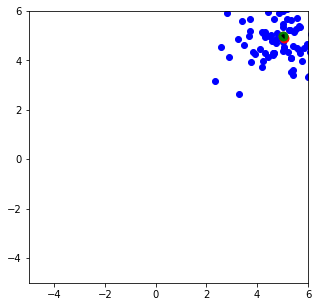

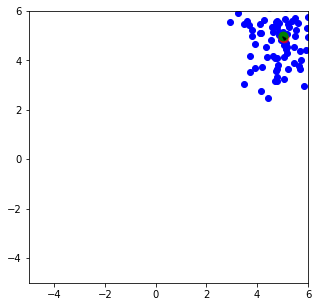

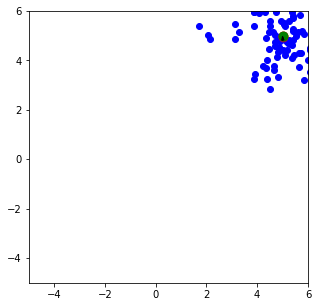

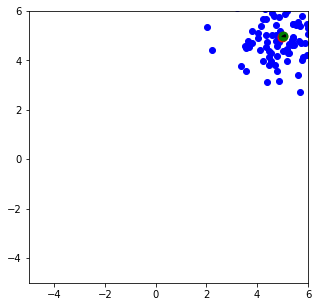

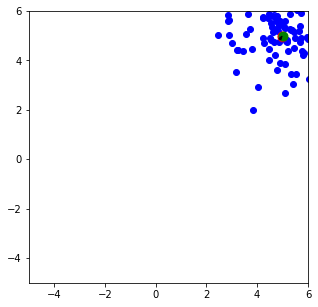

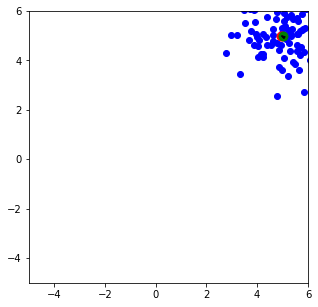

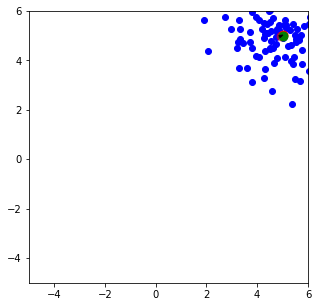

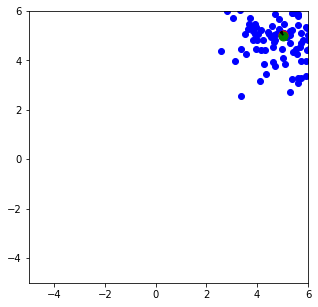

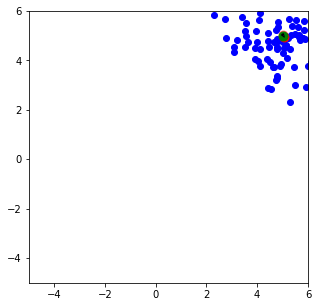

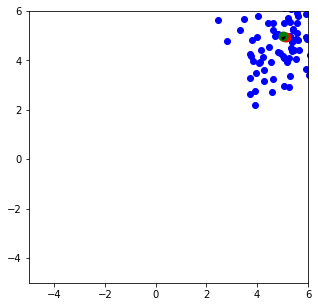

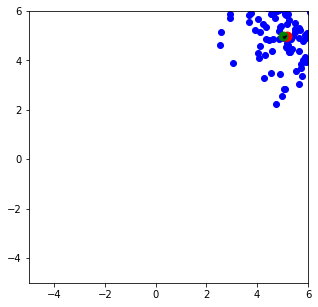

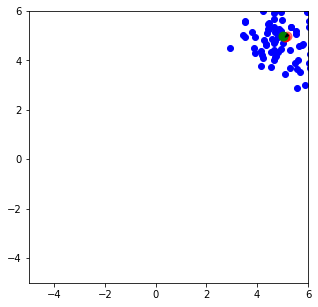

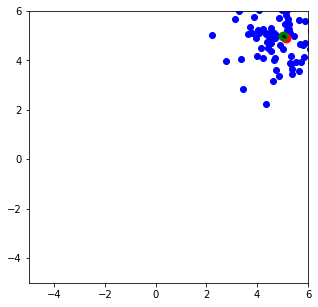

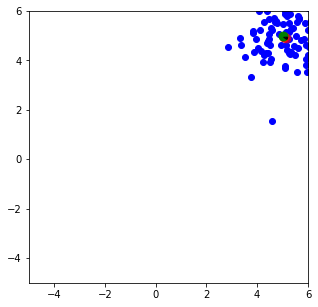

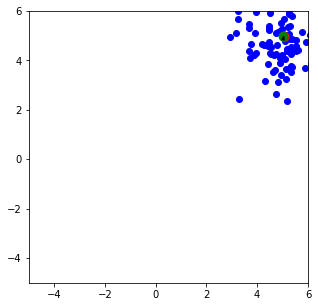

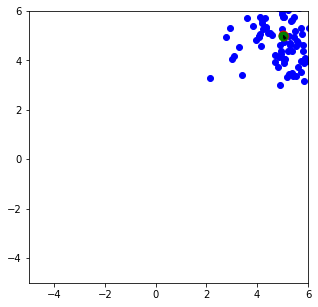

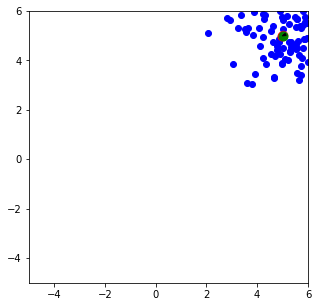

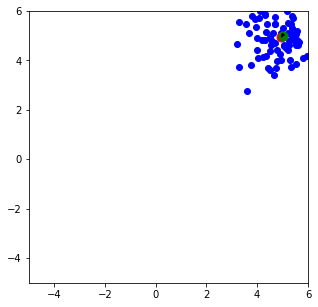

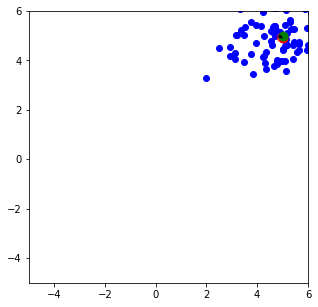

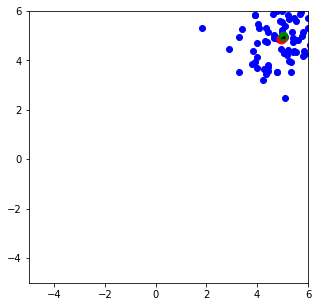

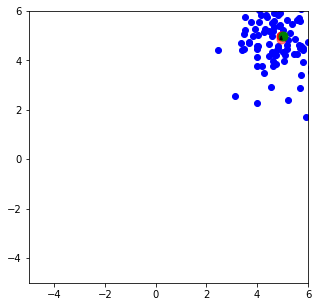

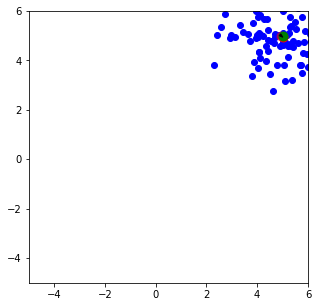

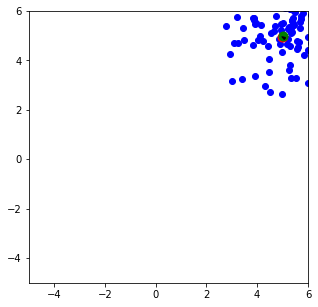

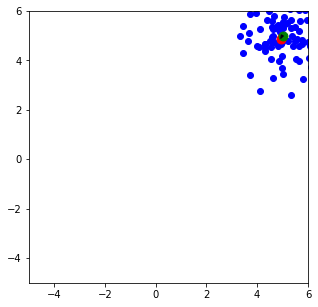

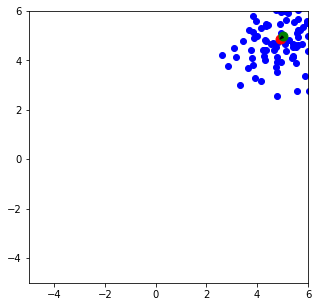

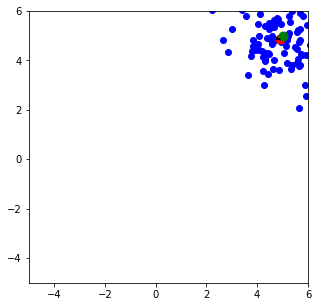

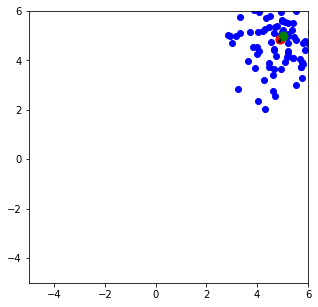

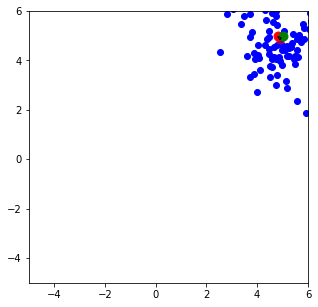

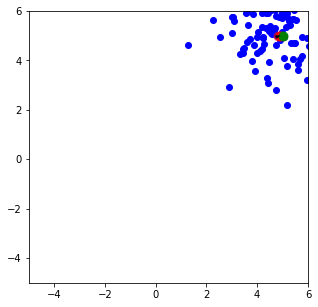

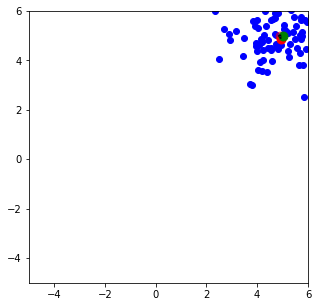

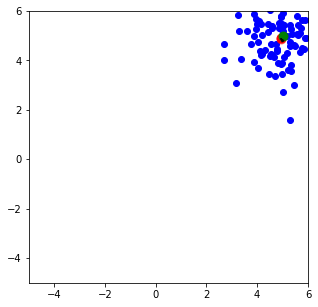

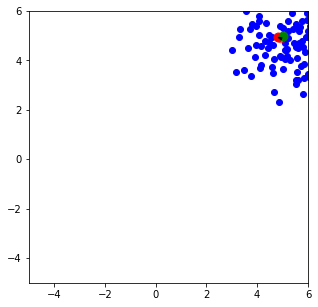

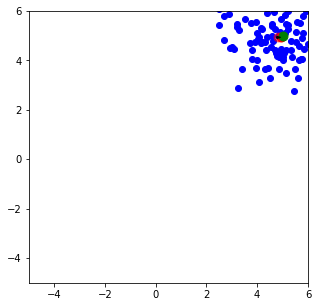

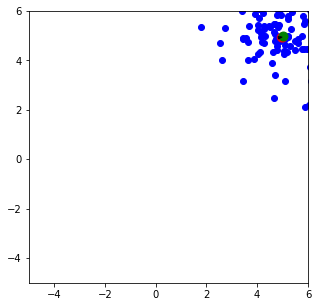

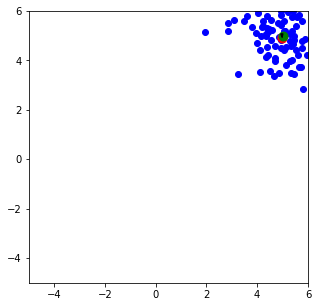

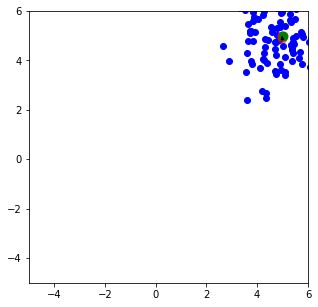

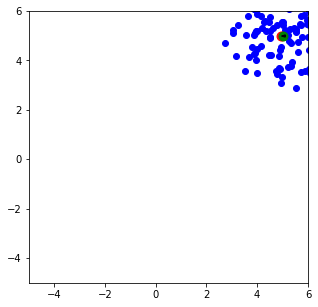

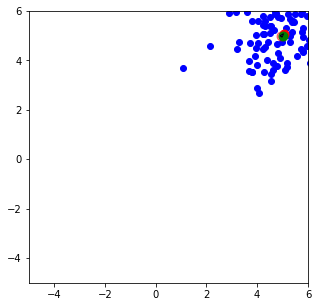

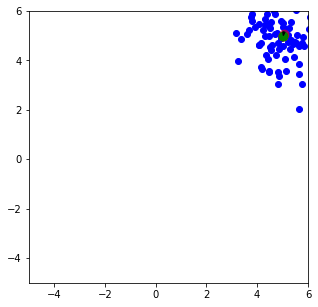

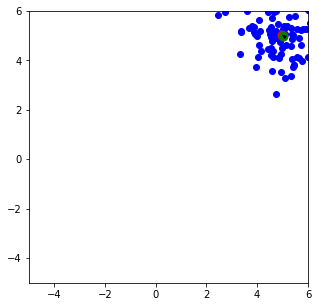

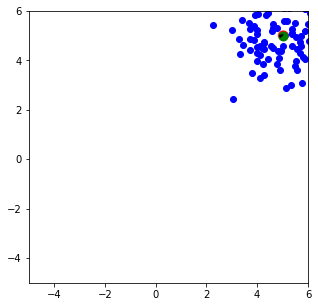

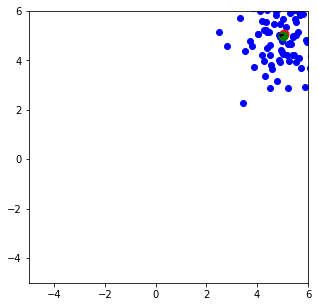

In [6]:
# train(mu, target, loss, lr=0.01, n_train=10, n_test=100, n_iter=100)

train(mu, target, loss, lr=0.1, n_train=100, n_test=100, n_iter=100, viz=True)